In [1]:
%matplotlib inline
import os
import numpy as np
import torch
from matplotlib import pyplot as plt

from collections import OrderedDict
import torch.nn as nn

from networks.uap import UAP
from utils.data import get_data_specs, get_data
from utils.utils import softmax, get_imagenet_dicts
from utils.network import get_network

In [2]:
MODEL_ARCH = "vgg19"
TARGET_CLASS = 150
TUAP_RESULT_PATH = "./vgg19_sea_lion"

NGPU=1
USE_CUDA=True
idx2label, _ = get_imagenet_dicts()
props = dict(facecolor='none', edgecolor='black', pad=5, alpha=0.5)

In [3]:
num_classes, (mean, std), input_size, num_channels = get_data_specs("imagenet")
std_tensor = torch.tensor(std).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
mean_tensor = torch.tensor(mean).unsqueeze(0).unsqueeze(-1).unsqueeze(-1)
if USE_CUDA:
    std_tensor = std_tensor.cuda()
    mean_tensor = mean_tensor.cuda()

_, data_test = get_data("imagenet", pretrained_dataset="imagenet")

data_test_loader = torch.utils.data.DataLoader(data_test,
                                                batch_size=1,
                                                shuffle=True,
                                                num_workers=10,
                                                pin_memory=True)
test_iter = iter(data_test_loader)

In [4]:
target_model = get_network(MODEL_ARCH, input_size=input_size, num_classes=num_classes)
target_model = torch.nn.DataParallel(target_model, device_ids=list(range(NGPU)))

tuap_generator = UAP(shape=(input_size, input_size),
                        num_channels=num_channels,
                        mean=mean,
                        std=std,
                        use_cuda=USE_CUDA)
model_weights_path = os.path.join(TUAP_RESULT_PATH, "checkpoint.pth.tar")
network_data = torch.load(model_weights_path)
tuap_generator.load_state_dict(network_data['state_dict'])

tuap_perturbed_net = nn.Sequential(OrderedDict([('generator', tuap_generator), ('target_model', target_model)]))
tuap_perturbed_net = torch.nn.DataParallel(tuap_perturbed_net, device_ids=list(range(NGPU)))

tuap_perturbed_net.module.target_model.eval()
tuap_perturbed_net.module.generator.eval()

if USE_CUDA:
    tuap_generator.cuda()
    tuap_perturbed_net.cuda()

In [5]:
def plot(img1, img1_logit,
         img2, img2_logit,
         img1_img2, img1_img2_logit,
         center_label):
    
    get_imagenet_dicts()
    
    fig = plt.figure(figsize=(27,6))
    
    ax = plt.subplot(1,5,1)
    ax.imshow(img1, vmin=0, vmax=1)
    cl_img_1 = np.argmax(img1_logit)
    img1_label = idx2label[cl_img_1].replace("_", " ")
    ax.set_xlabel("{} ({:.2f}%)".format(img1_label, softmax(img1_logit[0])[cl_img_1]*100))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = plt.subplot(1,5,2)
    ax.imshow(img2, vmin=0, vmax=1)
    cl_img_2 = np.argmax(img2_logit)
    img2_label = idx2label[cl_img_2].replace("_", " ")
    ax.set_xlabel("{}".format(center_label))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = plt.subplot(1,5,3)
    ax.imshow(img1_img2, vmin=0, vmax=1)
    cl_img_3 = np.argmax(img1_img2_logit)
    img3_label = idx2label[cl_img_3].replace("_", " ")
    ax.set_xlabel("{} ({:.2f}%)".format(img3_label, softmax(img1_img2_logit[0])[cl_img_3]*100))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Lgit plots 
    ax = plt.subplot(1,5,4)
    ax.scatter(img1_logit[0], img1_img2_logit[0], s=2, color="blue")
    ax.set_xlabel("$L_a$")
    ax.set_ylabel("$L_c$", rotation=0)
    
    # Calculating the covariance matrices
    logit_mat1 = np.concatenate((img1_logit, img1_img2_logit), axis=0)
    origin1 = np.mean(logit_mat1, axis=1)

    # Calculate Pearson coefficient
    pcc1 = np.corrcoef(logit_mat1)
    props = dict(facecolor='none', edgecolor='black', pad=5, alpha=0.5)
    ax.text(0.65, 0.05, "PCC: {:.2f}".format(pcc1[0,1]), transform=ax.transAxes, fontsize=20,
    verticalalignment='bottom', bbox=props)
    
    ax = plt.subplot(1,5,5)
    ax.scatter(img2_logit[0], img1_img2_logit[0], s=2, color="red")
    ax.set_xlabel("$L_b$")
    ax.set_ylabel("$L_c$", rotation=0)
    
    # Calculating the covariance matrices
    logit_mat2 = np.concatenate((img2_logit, img1_img2_logit), axis=0)
    
    # Calculate Pearson coefficient
    pcc2 = np.corrcoef(logit_mat2)
    ax.text(0.65, 0.05, "PCC: {:.2f}".format(pcc2[0,1]), transform=ax.transAxes, fontsize=20,
    verticalalignment='bottom', bbox=props)


    plt.tight_layout()
    return fig

In [6]:
img1, lbl1 = next(test_iter)
if USE_CUDA:
    img1 = img1.cuda()
    lbl1 = lbl1.cuda()

# Getting logits
logit1 = target_model(img1)
logit2 = tuap_perturbed_net(img1)

cl1 = torch.argmax(logit1)
cl2 = torch.argmax(logit2)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


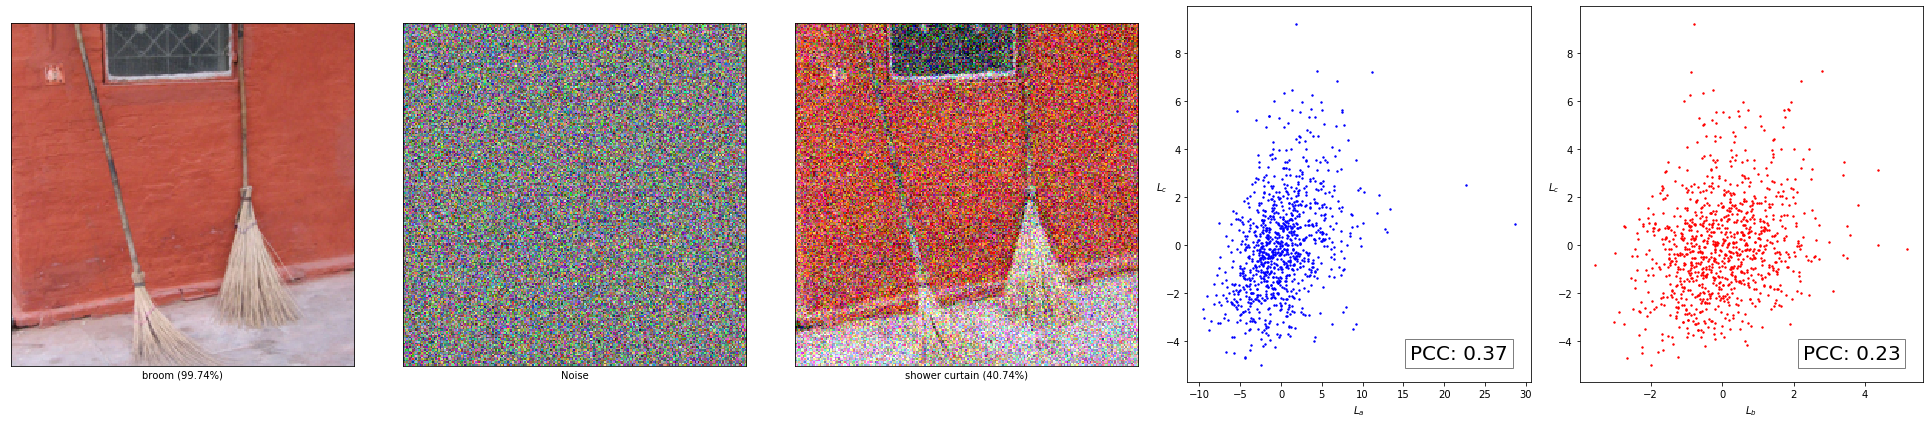

In [7]:
# Img + Gaussian Noise Image
noise_img = torch.randn_like(img1) * 0.2

### Perpearing the inputs
img1_logit = target_model(img1).cpu().detach().numpy()
plot_img1 = img1[0].cpu().detach().numpy() 
plot_img1 = np.transpose(plot_img1, (1, 2, 0))
plot_img1 = plot_img1 * std + mean

# Original img + Other image
noise_img_logit = target_model((noise_img - mean_tensor)/std_tensor).cpu().detach().numpy()
plot_noise_img = noise_img[0].cpu().detach().numpy()
plot_noise_img = np.transpose(plot_noise_img, (1, 2, 0)) + 0.5

img_noise_img = ((img1 * std_tensor + mean_tensor + noise_img) - mean_tensor)/std_tensor
img_noise_img_logit = target_model(img_noise_img).cpu().detach().numpy()
plot_img_noise_img = np.clip((plot_img1 + plot_noise_img - 0.5), 0, 1)

fig = plot(plot_img1, img1_logit, plot_noise_img, noise_img_logit, plot_img_noise_img, img_noise_img_logit, center_label="Noise")

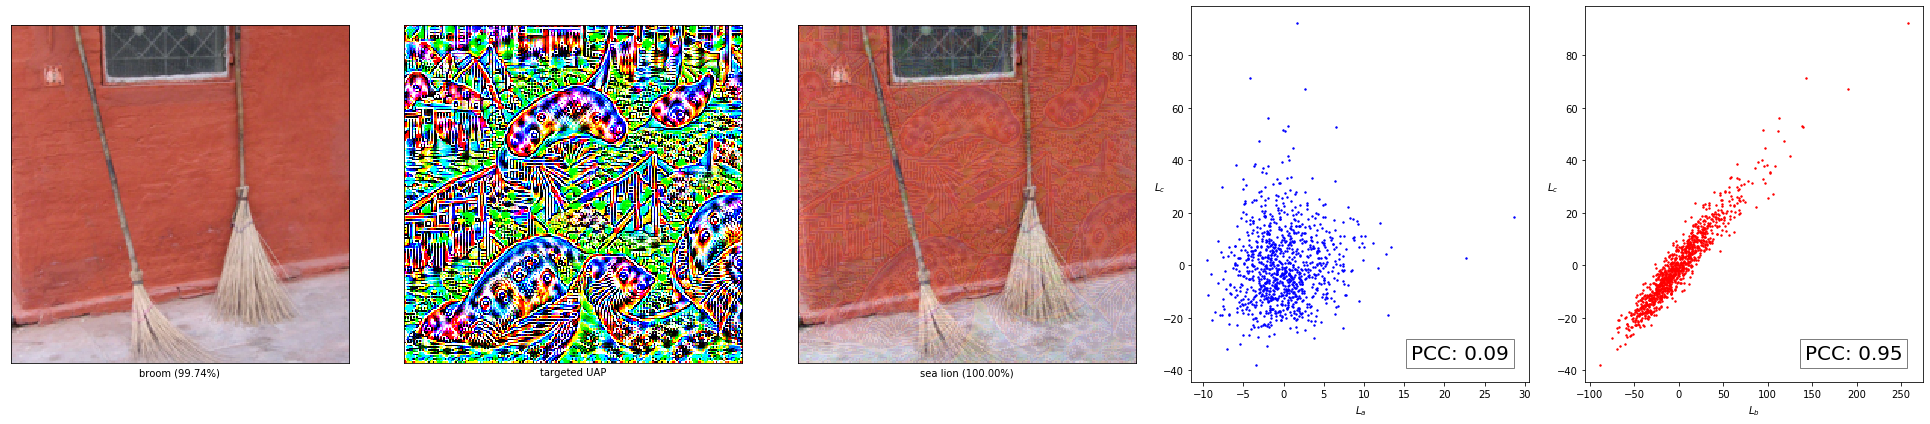

In [8]:
# Img + TUAP
tuap = torch.unsqueeze(tuap_generator.uap, dim=0)

### Perpearing the inputs
img1_logit = target_model(img1).cpu().detach().numpy()
plot_img1 = img1[0].cpu().detach().numpy() 
plot_img1 = np.transpose(plot_img1, (1, 2, 0))
plot_img1 = plot_img1 * std + mean

# Original img + Other image
tuap_logit = target_model((tuap-mean_tensor)/std_tensor).cpu().detach().numpy()
plot_tuap = tuap[0].cpu().detach().numpy()
plot_tuap = np.transpose(plot_tuap, (1, 2, 0))
plot_tuap_normal = plot_tuap + 0.5

plot_tuap_amp = plot_tuap/2+0.5
tuap_range = np.max(plot_tuap_amp) - np.min(plot_tuap_amp)
plot_tuap_amp = plot_tuap_amp/tuap_range + 0.5
plot_tuap_amp -= np.min(plot_tuap_amp) 

img_tuap = ((img1 * std_tensor + mean_tensor + tuap) - mean_tensor)/std_tensor
img_tuap_logit = target_model(img_tuap).cpu().detach().numpy()
tuap_logit_val = tuap_perturbed_net(img1)
plot_img_tuap = np.clip((plot_img1 + plot_tuap_normal - 0.5), 0, 1)

fig = plot(plot_img1, img1_logit, plot_tuap_amp, tuap_logit, plot_img_tuap, img_tuap_logit, center_label="targeted UAP")